# Horse Racing Dataset Visualizations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#Supresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)

1.4.2


In [2]:
# Requires CleanedHorses.csv, which was created in the HorseRacingDataCleaning notebook
df_cleaned = pd.read_csv('CleanedHorses.csv',
                         skipinitialspace=True, 
                         low_memory=False)

df_cleaned.head()

,date,venue_name,race_number,market_name,previous_margin,position_again,bf_odds,bf_odds_two_mins_out,vic_tote,vic_tote_two_mins_out,...,track_win_percent_norm,track_place_percent_norm,distance_win_percent_norm,distance_place_percent_norm,condition_win_percent_norm,condition_starts_norm,condition_place_percent_norm,prize_money_per_start_norm,bf_odds_place,target
0,2016-06-27,Echuca,3,R3 1200m Mdn,6.80,1.00,2.88,3.00,2.30,3.50,...,NaN,NaN,NaN,1.00,NaN,0.00,NaN,0.20,1.63,2.88
1,2016-06-27,Echuca,3,R3 1200m Mdn,20.80,2.00,15.00,18.00,11.20,11.70,...,NaN,NaN,NaN,1.00,NaN,0.33,NaN,0.47,4.20,4.20
2,2016-06-27,Echuca,3,R3 1200m Mdn,NaN,3.00,95.00,100.00,46.40,37.10,...,NaN,NaN,NaN,0.00,NaN,1.00,NaN,0.29,21.20,21.20
3,2016-06-27,Echuca,3,R3 1200m Mdn,4.00,NaN,20.00,17.00,13.20,14.20,...,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.11,5.27,0.00
4,2016-06-27,Echuca,3,R3 1200m Mdn,NaN,NaN,2.74,2.68,2.60,3.20,...,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.08,1.60,0.00


In [3]:
df_cleaned.set_index(['date','venue_name','race_number','market_name'], inplace=True)
df_cleaned.sort_index(level=['date','venue_name','race_number'], inplace=True)

In [4]:
df_grouped = df_cleaned.groupby(['date','venue_name','race_number','market_name'])

## Useful cleaning functions for the visualizations below:

In [5]:
#Removes races where a chosen column has any null values or where all values are the same
def column_cleaner(cleaned_df, grouped_df, column_name):
    non_null_indices = grouped_df[column_name].apply(lambda x: all(x.notnull())).\
        where(lambda x: x==True).dropna().index
    non_null_df = cleaned_df[cleaned_df.index.isin(non_null_indices)]
    
    non_null_grouped = non_null_df.groupby(['date','venue_name','race_number','market_name'])
    clean_indices = non_null_grouped[column_name].value_counts(normalize=True,dropna=False).\
        where(lambda x:x != 1).dropna().index.droplevel(column_name)
    new_cleaned_df = non_null_df[non_null_df.index.isin(clean_indices)]
    return new_cleaned_df

#Separates off winners of each race
def cleaned_win_df(cleaned_df):
    win_indices = cleaned_df['position_again'].apply(lambda x:x == 1)
    df_cleaned_win = cleaned_df[win_indices]
    return df_cleaned_win

## Graphing the feature distributions:

In [6]:
number_list = df_cleaned.select_dtypes('number').columns.tolist()
number_list.remove('position_again')
print('Number of numeric features:',len(number_list))

Number of numeric features: 156


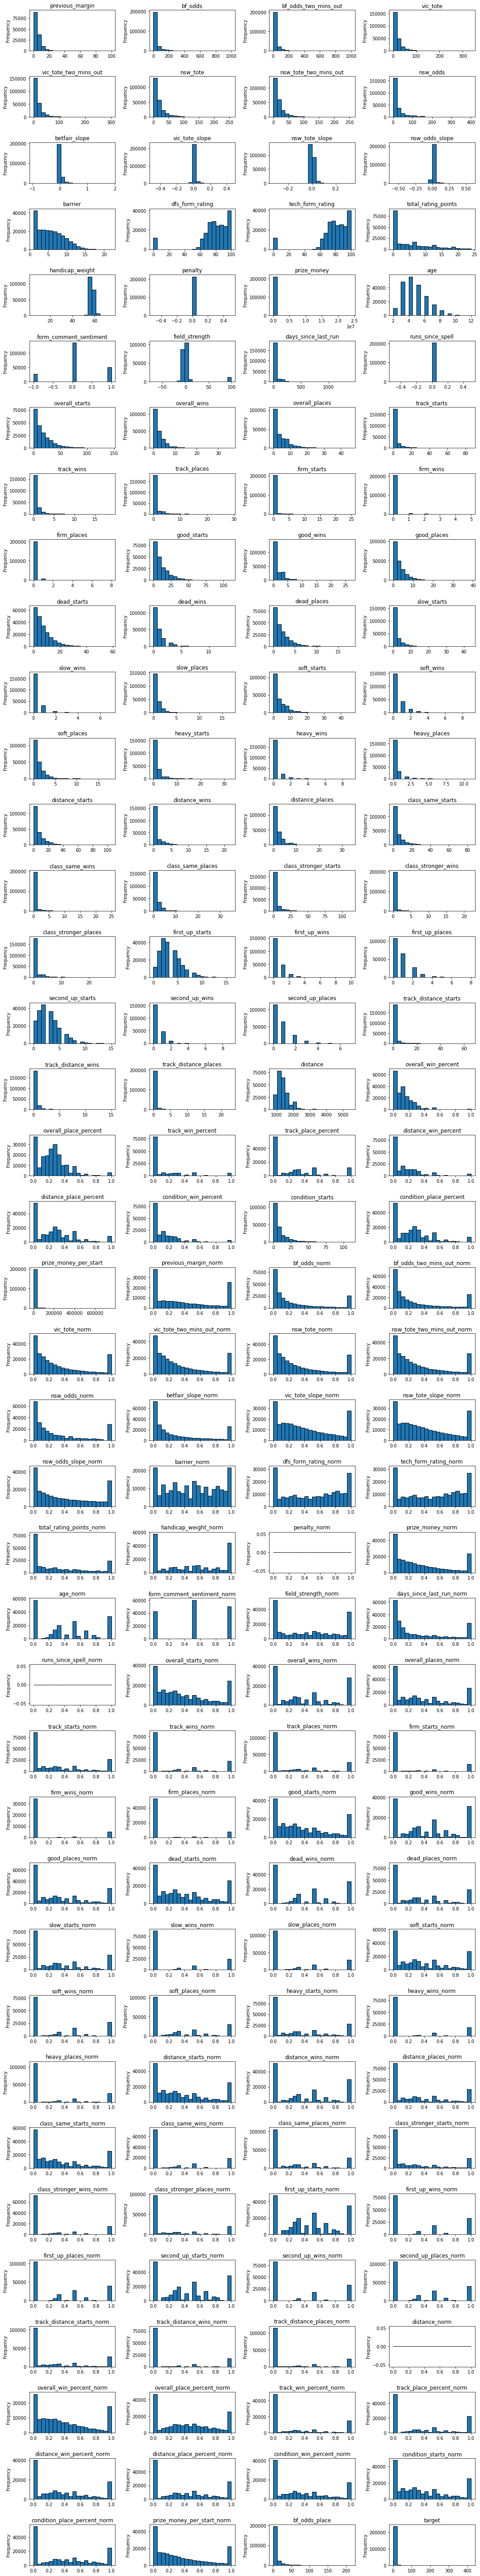

In [7]:
fig,ax = plt.subplots(39, 4)

m=0
for i in range(39):
    for j in range(4):
        df_cleaned[number_list[m]].plot(kind='hist', bins=20, ax=ax[i,j], figsize=(15,80),
                                        edgecolor='k').set_title(number_list[m])
        m+=1
        
plt.tight_layout()

## Visualizations for determining whether a feature has a significant effect on wins:

### Horse gender:

In [8]:
#Removes races where only one horse gender is represented
sex_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'sex')
sex_pop_cleaned_win = cleaned_win_df(sex_pop_cleaned)

In [9]:
#General percentage of horse genders for races where multiple genders are represented  
sex_pop_cleaned['sex'].value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

Gelding   0.57
Mare      0.27
Filly     0.13
Colt      0.03
Horse     0.01
Name: sex, dtype: float64

In [10]:
sex_pop_cleaned_win['sex'].value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

Gelding   0.57
Mare      0.24
Filly     0.15
Colt      0.04
Horse     0.01
Name: sex, dtype: float64

In [11]:
horse_sex_pop = sex_pop_cleaned['sex'].value_counts(dropna=False,normalize=True)\
    .sort_values(ascending=False).drop('Unknown')
horse_sex_win = sex_pop_cleaned_win['sex'].value_counts(dropna=False,normalize=True)\
    .sort_values(ascending=False).drop('Unknown')
horse_sex_percent_difference = (horse_sex_win - horse_sex_pop)/horse_sex_pop
horse_sex_percent_difference

Gelding   -0.00
Mare      -0.11
Filly      0.14
Colt       0.44
Horse      0.12
Name: sex, dtype: float64

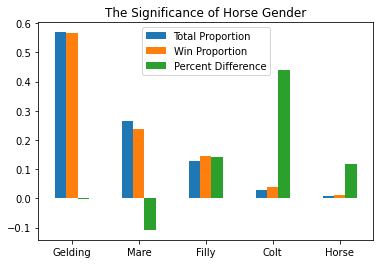

In [12]:
index1 = ['Gelding','Mare','Filly','Colt','Horse']
df1 = pd.DataFrame({'Total Proportion': horse_sex_pop,'Win Proportion': horse_sex_win,
                    'Percent Difference': horse_sex_percent_difference}, index=index1)
ax = df1.plot.bar(rot=0,title='The Significance of Horse Gender')

### Normalized horse age:

In [13]:
#Removing races where there is only one age
age_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'age_norm')

age_pop_cleaned_win = cleaned_win_df(age_pop_cleaned)

In [14]:
age_pop_cleaned['age_norm'].describe()

count   190370.00
mean         0.41
std          0.36
min          0.00
25%          0.00
50%          0.33
75%          0.67
max          1.00
Name: age_norm, dtype: float64

In [15]:
age_pop_cleaned_win['age_norm'].describe()

count   19160.00
mean        0.32
std         0.34
min         0.00
25%         0.00
50%         0.25
75%         0.50
max         1.00
Name: age_norm, dtype: float64

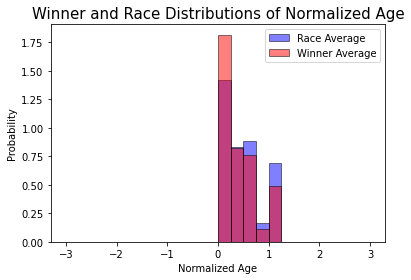

In [16]:
data2a = age_pop_cleaned['age_norm'].dropna().values
data2b = age_pop_cleaned_win['age_norm'].dropna().values

plt.title('Winner and Race Distributions of Normalized Age', fontsize=15)
plt.hist(data2a, density=True, bins=24, range=(-3,3), label='Race Average', 
         color='b', alpha=.5, edgecolor='k')
plt.hist(data2b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Normalized Age')
plt.ylabel('Probability');

#### Does condition affect the win distribution of age? Specifically, do older horses perform worse in bad conditions?

In [17]:
condit_age_pop = age_pop_cleaned[age_pop_cleaned.condition == 'HEAVY']

In [18]:
condit_age_pop_win = cleaned_win_df(condit_age_pop)

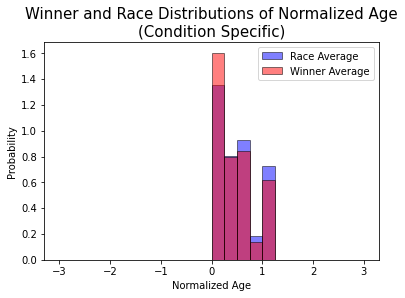

In [19]:
data2c = condit_age_pop['age_norm'].dropna().values
data2d = condit_age_pop_win['age_norm'].dropna().values

plt.title('Winner and Race Distributions of Normalized Age\n(Condition Specific)', fontsize=15)
plt.hist(data2c, density=True, bins=24, range=(-3,3), label='Race Average', 
         color='b', alpha=.5, edgecolor='k')
plt.hist(data2d, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Normalized Age')
plt.ylabel('Probability');

#### It appears as though bad track conditions actually level out the age discrepancies, maybe because they have more experience with those bad conditions.

### Normalized horse weight handicap:

In [20]:
#Removing races where there is only one weight
weight_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'handicap_weight_norm')
weight_pop_cleaned_win = cleaned_win_df(weight_pop_cleaned)

In [21]:
weight_pop_cleaned['handicap_weight_norm'].describe()

count   207524.00
mean         0.46
std          0.39
min          0.00
25%          0.00
50%          0.44
75%          0.83
max          1.00
Name: handicap_weight_norm, dtype: float64

In [22]:
weight_pop_cleaned_win['handicap_weight_norm'].describe()

count   21043.00
mean        0.54
std         0.38
min         0.00
25%         0.18
50%         0.57
75%         1.00
max         1.00
Name: handicap_weight_norm, dtype: float64

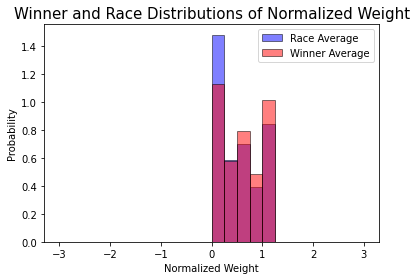

In [23]:
data3a = weight_pop_cleaned['handicap_weight_norm'].dropna().values
data3b = weight_pop_cleaned_win['handicap_weight_norm'].dropna().values

plt.title('Winner and Race Distributions of Normalized Weight', fontsize=15)
plt.hist(data3a, density=True, bins=24, range=(-3,3), label='Race Average', 
         color='b', alpha=.5, edgecolor='k')
plt.hist(data3b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Normalized Weight')
plt.ylabel('Probability');

### Normalized prize money per start:

In [24]:
money_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'prize_money_per_start_norm')
money_pop_cleaned_win = cleaned_win_df(weight_pop_cleaned)

In [25]:
money_pop_cleaned['prize_money_per_start_norm'].describe()

count   165687.00
mean         0.36
std          0.32
min          0.00
25%          0.09
50%          0.27
75%          0.56
max          1.00
Name: prize_money_per_start_norm, dtype: float64

In [26]:
#Winner prize money 
money_pop_cleaned_win['prize_money_per_start_norm'].describe()

count   20057.00
mean        0.54
std         0.36
min         0.00
25%         0.23
50%         0.52
75%         0.98
max         1.00
Name: prize_money_per_start_norm, dtype: float64

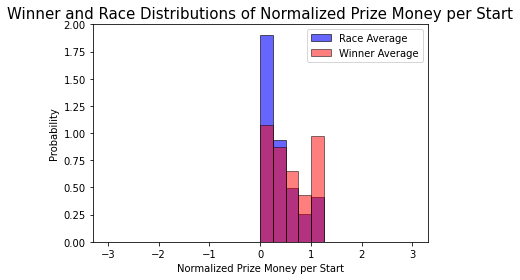

In [27]:
data4a = money_pop_cleaned['prize_money_per_start_norm'].dropna().values
data4b = money_pop_cleaned_win['prize_money_per_start_norm'].dropna().values

plt.title('Winner and Race Distributions of Normalized Prize Money per Start',
          fontsize=15)
plt.hist(data4a, density=True, bins=24, range=(-3,3), label='Race Average',
         color='b', alpha=.6, edgecolor='k')
plt.hist(data4b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Normalized Prize Money per Start')
plt.ylabel('Probability');

### Normalized overall wins percent:

In [28]:
overall_win_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'overall_win_percent_norm')
overall_win_pop_cleaned_win = cleaned_win_df(overall_win_pop_cleaned)

In [29]:
overall_win_pop_cleaned['overall_win_percent_norm'].describe()

count   142458.00
mean         0.39
std          0.32
min          0.00
25%          0.11
50%          0.31
75%          0.60
max          1.00
Name: overall_win_percent_norm, dtype: float64

In [30]:
overall_win_pop_cleaned_win['overall_win_percent_norm'].describe()

count   14523.00
mean        0.49
std         0.35
min         0.00
25%         0.19
50%         0.44
75%         0.82
max         1.00
Name: overall_win_percent_norm, dtype: float64

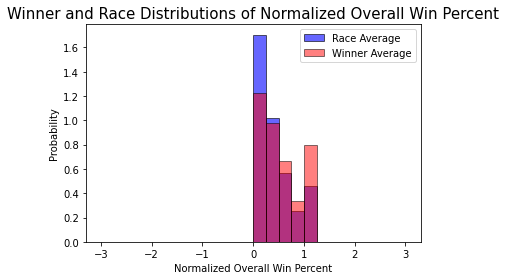

In [31]:
data5a = overall_win_pop_cleaned['overall_win_percent_norm'].dropna().values
data5b = overall_win_pop_cleaned_win['overall_win_percent_norm'].dropna().values

plt.title('Winner and Race Distributions of Normalized Overall Win Percent',
          fontsize=15)
plt.hist(data5a, density=True, bins=24, range=(-3,3), label='Race Average',
         color='b', alpha=.6, edgecolor='k')
plt.hist(data5b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Normalized Overall Win Percent')
plt.ylabel('Probability');

#### There is high variance in the 100% column (aka beginner's luck). How many races before the 100% column is properly represented? That is, how many races is considered statistically significant?

#### It seems that a minimum of 5 races for all horses in the race gives the percent difference bar graph an exponential appearance. The other Github file has the graph showing this behavior.

In [32]:
overall_win_pop_grouped = overall_win_pop_cleaned.groupby(['date','venue_name','race_number','market_name'])
overall_starts_indices = overall_win_pop_grouped['overall_starts'].agg('min').where(lambda x:x >= 5).dropna().index
overall_starts_cleaned = overall_win_pop_cleaned[overall_win_pop_cleaned.index.isin(overall_starts_indices)]
overall_starts_cleaned_win = cleaned_win_df(overall_starts_cleaned)

In [33]:
overall_starts_cleaned['overall_win_percent_norm'].describe()

count   93752.00
mean        0.42
std         0.32
min         0.00
25%         0.15
50%         0.36
75%         0.64
max         1.00
Name: overall_win_percent_norm, dtype: float64

In [34]:
overall_starts_cleaned_win['overall_win_percent_norm'].describe()

count   9673.00
mean       0.52
std        0.34
min        0.00
25%        0.24
50%        0.48
75%        0.83
max        1.00
Name: overall_win_percent_norm, dtype: float64

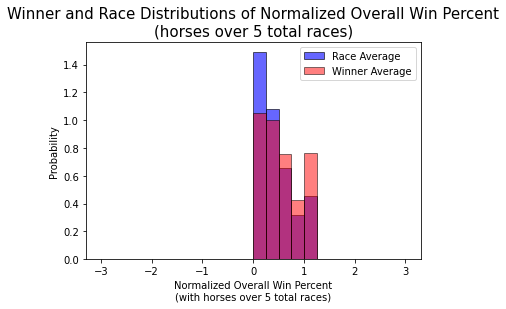

In [35]:
data6a = overall_starts_cleaned['overall_win_percent_norm'].dropna().values
data6b = overall_starts_cleaned_win['overall_win_percent_norm'].dropna().values

plt.title('Winner and Race Distributions of Normalized Overall Win Percent\n(horses over 5 total races)',
          fontsize=15)
plt.hist(data6a, density=True, bins=24, range=(-3,3), label='Race Average',
         color='b', alpha=.6, edgecolor='k')
plt.hist(data6b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Normalized Overall Win Percent\n(with horses over 5 total races)')
plt.ylabel('Probability');

### Barrier:

In [36]:
barrier_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'barrier')
barrier_grouped = barrier_pop_cleaned.groupby(['date','venue_name','race_number','market_name'])
barrier_indices = barrier_grouped['barrier'].value_counts().where(lambda x:x == 1).dropna().index.droplevel('barrier')
barrier_pop_cleaned = barrier_pop_cleaned[barrier_pop_cleaned.index.isin(barrier_indices)]
barrier_pop_cleaned_win = cleaned_win_df(barrier_pop_cleaned)

In [37]:
barrier_pop = barrier_pop_cleaned['barrier'].value_counts(normalize=True).sort_index().drop([18.00,19.00,20.00])
barrier_win = barrier_pop_cleaned_win['barrier'].value_counts(normalize=True).sort_index().drop(18.00)
barrier_percent_difference = (barrier_win - barrier_pop)/barrier_pop
barrier_percent_difference

1.00     0.22
2.00     0.04
3.00     0.06
4.00     0.11
5.00     0.12
6.00     0.08
7.00    -0.05
8.00    -0.12
9.00    -0.14
10.00   -0.21
11.00   -0.23
12.00   -0.21
13.00   -0.37
14.00   -0.37
15.00   -0.23
16.00   -0.50
17.00   -0.39
21.00     NaN
22.00     NaN
Name: barrier, dtype: float64

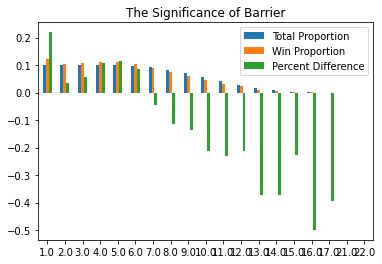

In [38]:
index7 = barrier_percent_difference.index
df7 = pd.DataFrame({'Total Proportion': barrier_pop,'Win Proportion': barrier_win,
                    'Percent Difference': barrier_percent_difference}, index=index7)
ax = df7.plot.bar(rot=0, title='The Significance of Barrier')

#### Does the length of a race negate or alter the effect of starting barrier?

In [39]:
barr_dist_indices = barrier_pop_cleaned['distance'].where(lambda x:x>=1800).dropna().index
barr_dist_cleaned = barrier_pop_cleaned[barrier_pop_cleaned.index.isin(barr_dist_indices)]
barr_dist_cleaned_win = cleaned_win_df(barr_dist_cleaned)

In [40]:
barr_dist_pop = barr_dist_cleaned['barrier'].value_counts(normalize=True).sort_index().drop(18.00)
barr_dist_win = barr_dist_cleaned_win['barrier'].value_counts(normalize=True).sort_index().drop(18.00)
barr_dist_percent_difference = (barr_dist_win - barr_dist_pop)/barr_dist_pop
barr_dist_percent_difference

1.00     0.19
2.00     0.03
3.00     0.07
4.00     0.16
5.00     0.11
6.00     0.05
7.00     0.00
8.00    -0.06
9.00    -0.13
10.00   -0.27
11.00   -0.21
12.00   -0.36
13.00   -0.38
14.00   -0.36
15.00   -0.62
16.00   -0.84
17.00     NaN
19.00     NaN
20.00     NaN
Name: barrier, dtype: float64

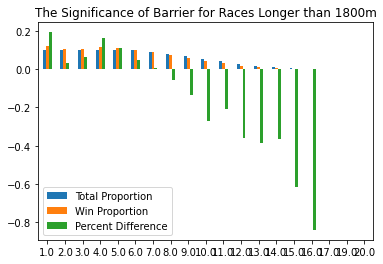

In [41]:
index7a = barr_dist_percent_difference.index
df7a = pd.DataFrame({'Total Proportion': barr_dist_pop,'Win Proportion': barr_dist_win,
                    'Percent Difference': barr_dist_percent_difference}, index=index7a)
ax = df7a.plot.bar(rot=0, title='The Significance of Barrier for Races Longer than 1800m')

#### There doesn't appear to be a dramatic difference for races longer than 1800m.

### Jockey gender: 

#### Overall percentage of men and women in races where both are represented:

In [42]:
#Drops races where there is only one jockey gender, meaning that the other gender can't win
jockey_sex_cleaned = column_cleaner(df_cleaned, df_grouped, 'jockey_sex')
jockey_sex_cleaned_win = cleaned_win_df(jockey_sex_cleaned)

In [43]:
jockey_sex_cleaned['jockey_sex'].value_counts(normalize=True).drop('Unknown')
#This amount is the sum of all 'male' and 'female' jockeys added together and THEN 'normalized'

Male     0.74
Female   0.24
Name: jockey_sex, dtype: float64

#### Win percentage of those races:

In [44]:
#Isolates wins in races with both jockey genders represented
jockey_sex_cleaned_win['jockey_sex'].value_counts(normalize=True, dropna=False).drop('Unknown')

Male     0.77
Female   0.20
Name: jockey_sex, dtype: float64

In [45]:
#Finding the percent difference between win and total
jockey_sex_pop = jockey_sex_cleaned['jockey_sex'].value_counts(normalize=True,
                                                            dropna=False).drop('Unknown').values
jockey_sex_win = jockey_sex_cleaned_win['jockey_sex'].value_counts(normalize=True,
                                                                dropna=False).drop('Unknown').values
jockey_sex_percent_difference = (jockey_sex_win - jockey_sex_pop)/jockey_sex_pop

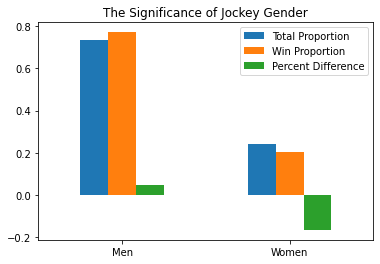

In [46]:
index8 = ['Men','Women']
df8 = pd.DataFrame({'Total Proportion': jockey_sex_pop,'Win Proportion': jockey_sex_win ,
                    'Percent Difference': jockey_sex_percent_difference}, index=index8)
ax = df8.plot.bar(rot=0, title='The Significance of Jockey Gender')

### Do blinkers make a difference?

In [47]:
blinkers_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'blinkers')
blinkers_pop_cleaned_win = cleaned_win_df(blinkers_pop_cleaned)
print('Rows in blinkers_pop_cleaned:',len(blinkers_pop_cleaned))
print('Rows in blinkers_pop_cleaned_win:',len(blinkers_pop_cleaned_win))

Rows in blinkers_pop_cleaned: 71704
Rows in blinkers_pop_cleaned_win: 6946


In [48]:
#General percentage of horse genders for races where multiple genders are represented  
blinkers_pop_cleaned['blinkers'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

False   0.86
True    0.14
Name: blinkers, dtype: float64

In [49]:
blinkers_pop_cleaned_win['blinkers'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

False   0.86
True    0.14
Name: blinkers, dtype: float64

#### Blinkers appear to make no difference.

### How many races before previous finishes become irrelevant?

#### The distribution after 1 start:

In [50]:
last_start_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'last_start1')
last_start_pop_cleaned_win = cleaned_win_df(last_start_pop_cleaned)

In [51]:
#The percent difference between the previous finish of the winner and all horses:
last_start_pop = last_start_pop_cleaned['last_start1'].value_counts(normalize=True,
                                                                 dropna=False)
last_start_win = last_start_pop_cleaned_win['last_start1'].value_counts(normalize=True,
                                                                     dropna=False)
last_start_percent_difference = (last_start_win - last_start_pop)/last_start_pop
last_start_percent_difference

1         -0.06
2         -0.09
3         -0.12
4         -0.18
5         -0.16
6         -0.28
7         -0.21
8         -0.19
9         -0.26
fell       0.20
scratch   -0.13
ten+      -0.28
Name: last_start1, dtype: float64

In [52]:
index9 = ['1','2','3','4','5','6','7','8','9','ten+','scratch','fell','none']
df9 = pd.DataFrame({'Total Proportion': last_start_pop,'Win Proportion': last_start_win,
                    'Percent Difference': last_start_percent_difference}, index=index9)

#### After 5 starts:

In [53]:
last_start_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'last_start5')
last_start_pop_cleaned_win = cleaned_win_df(last_start_pop_cleaned)

In [54]:
#Finding the percent difference between win and total
last_start_pop = last_start_pop_cleaned['last_start5'].value_counts(normalize=True,
                                                                 dropna=False)
last_start_win = last_start_pop_cleaned_win['last_start5'].value_counts(normalize=True,
                                                                     dropna=False)
last_start_percent_difference = (last_start_win - last_start_pop)/last_start_pop

In [55]:
index10 = ['1','2','3','4','5','6','7','8','9','ten+','scratch','fell','none']
df10 = pd.DataFrame({'Total Proportion': last_start_pop,'Win Proportion': last_start_win,
                    'Percent Difference': last_start_percent_difference}, index=index10)

#### After 10 starts:

In [56]:
last_start_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'last_start10')
last_start_pop_cleaned_win = cleaned_win_df(last_start_pop_cleaned)

In [57]:
#Finding the percent difference between win and total
last_start_pop = last_start_pop_cleaned['last_start10'].value_counts(normalize=True,
                                                                 dropna=False)
last_start_win = last_start_pop_cleaned_win['last_start10'].value_counts(normalize=True,
                                                                     dropna=False)
last_start_percent_difference = (last_start_win - last_start_pop)/last_start_pop

In [58]:
index11 = ['1','2','3','4','5','6','7','8','9','ten+','scratch','fell','none']
df11 = pd.DataFrame({'Total Proportion': last_start_pop,'Win Proportion': last_start_win,
                    'Percent Difference': last_start_percent_difference}, index=index11)

#### Graphing form data:

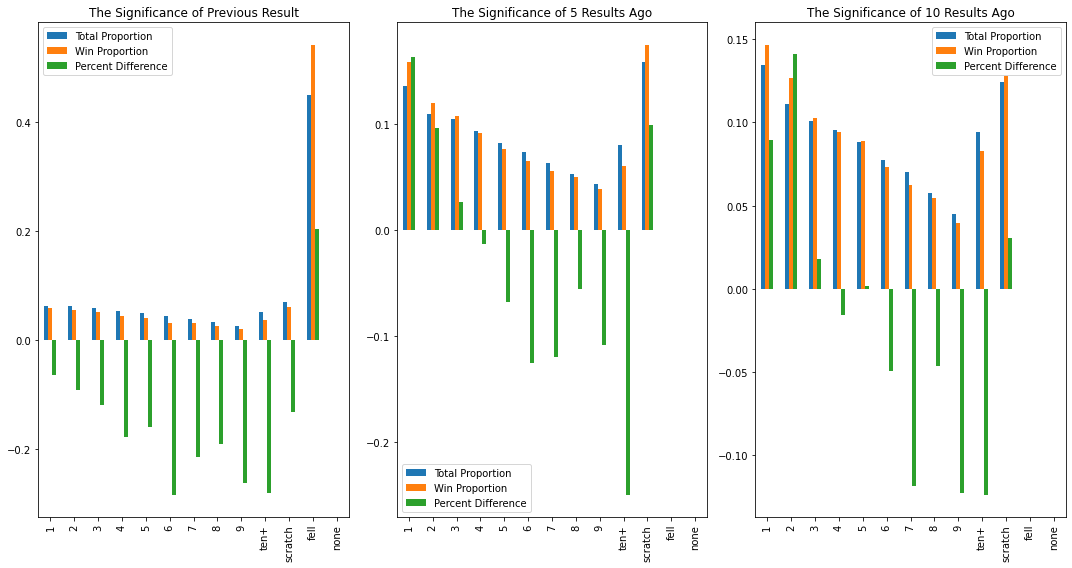

In [59]:
fig,ax1 = plt.subplots(1, 3)

df9.plot.bar(ax=ax1[0],figsize=(15, 8)).set_title('The Significance of Previous Result')
df10.plot.bar(ax=ax1[1],figsize=(15, 8)).set_title('The Significance of 5 Results Ago')
df11.plot.bar(ax=ax1[2],figsize=(15, 8)).set_title('The Significance of 10 Results Ago')

plt.tight_layout()

#### The larger win and total portions in the 5 and 10 results ago categories are likely because the horse is more of a veteran.

## How often would you win and what would be your expected return if you always bet on the favorite?

In [60]:
#Removing races where there is only one odds value
odds_cleaned = column_cleaner(df_cleaned, df_grouped, 'bf_odds')

In [61]:
#creates dataframe with a unique index
odds_cleaned.sort_index(level=['date','venue_name','race_number'],inplace=True)
odds_cleaned.reset_index(inplace=True)
odds_grouped = odds_cleaned.groupby(['date','venue_name','race_number','market_name'])

odds_cleaned.head()

,date,venue_name,race_number,market_name,previous_margin,position_again,bf_odds,bf_odds_two_mins_out,vic_tote,vic_tote_two_mins_out,...,track_win_percent_norm,track_place_percent_norm,distance_win_percent_norm,distance_place_percent_norm,condition_win_percent_norm,condition_starts_norm,condition_place_percent_norm,prize_money_per_start_norm,bf_odds_place,target
0,2016-06-27,Echuca,3,R3 1200m Mdn,6.80,1.00,2.88,3.00,2.30,3.50,...,NaN,NaN,NaN,1.00,NaN,0.00,NaN,0.20,1.63,2.88
1,2016-06-27,Echuca,3,R3 1200m Mdn,20.80,2.00,15.00,18.00,11.20,11.70,...,NaN,NaN,NaN,1.00,NaN,0.33,NaN,0.47,4.20,4.20
2,2016-06-27,Echuca,3,R3 1200m Mdn,NaN,3.00,95.00,100.00,46.40,37.10,...,NaN,NaN,NaN,0.00,NaN,1.00,NaN,0.29,21.20,21.20
3,2016-06-27,Echuca,3,R3 1200m Mdn,4.00,NaN,20.00,17.00,13.20,14.20,...,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.11,5.27,0.00
4,2016-06-27,Echuca,3,R3 1200m Mdn,NaN,NaN,2.74,2.68,2.60,3.20,...,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.08,1.60,0.00


In [62]:
#finds index of favorite for every race
favorite_indices = odds_grouped['bf_odds'].idxmin()

#finds row for each favorite
favorite_cleaned = odds_cleaned.loc[favorite_indices]

#finds favorites that won
favorite_win = cleaned_win_df(favorite_cleaned)

favorite_pop_count = len(favorite_cleaned)
favorite_win_count = len(favorite_win)

#finds average win of favorite that won
average = favorite_win['bf_odds'].mean()

print('Number of favorites:',favorite_pop_count)
print('Number of favorites that win:',favorite_win_count)
print('Average odds of favorite that wins:',average)

Number of favorites: 24172
Number of favorites that win: 8367
Average odds of favorite that wins: 2.944801003944066


### How often the favorite wins:

In [63]:
print('{0:.2f} %'.format(favorite_win_count/favorite_pop_count*100))

34.61 %


#### Similar to value found here:
https://betmix.com/how-often-does-the-favorite-win-a-horse-race/#:~:text=On%20average%20favorites%20win%20about,dirt%20races%20than%20turf%20races.


### The expected return if betting 1 dollar on favorite every race:

In [64]:
(average*favorite_win_count - favorite_pop_count)/favorite_pop_count

0.01932607976170782